In [2]:
import numpy as np
from numpy import fft,pi
import scipy.signal
import cPickle as pickle

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import ps_utils_new
import imp
imp.reload(ps_utils_new)
# from plot_styling import dark
import mwa_utils
imp.reload(mwa_utils)

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace
from scipy.linalg import sqrtm,inv

In [3]:
# LOAD LITERATURE IR POWER SPECTRA (Zemcov+ 14)

dat_dir = '/home/abrahamn/21cmIRxcor/zemcov14_data/'
ell_Cell_ciber = np.genfromtxt(dat_dir+'zemcov14_CIBER_data_with_errors_Cl.txt',skip_header=4,delimiter=',')
ell_Cell_eormodel = np.genfromtxt(dat_dir+'zemcov14_eor_Cl.txt',skip_header=1,delimiter=',')

# CIBER's measurements are of \lambda*I_\lambda, which can be converted to I_f by dividing by f 
# see https://www.evernote.com/shard/s316/nl/2147483647/1d5cc7be-446f-4933-9450-629dd63020c4/
convert_to_kJy_per_sr = 1.e-9/(3.e8/1.1e-6)/(1.e3*1.e-26)
print(convert_to_kJy_per_sr)

ciber_ell = ell_Cell_ciber[1::3,0]
ciber_dell = ciber_ell[1:]-ciber_ell[:-1]
ciber_delta = ell_Cell_ciber[1::3,1]*convert_to_kJy_per_sr
ciber_ddelta_plus = np.abs(ell_Cell_ciber[1::3,1]-ell_Cell_ciber[0::3,1])*convert_to_kJy_per_sr
ciber_ddelta_minus = np.abs(ell_Cell_ciber[2::3,1]-ell_Cell_ciber[1::3,1])*convert_to_kJy_per_sr
ciber_ddelta = (ciber_ddelta_plus+ciber_ddelta_minus)/2.+1.e-3

eormodel_ell = ell_Cell_eormodel[:,1]*convert_to_kJy_per_sr
eormodel_delta = ell_Cell_eormodel[:,1]*convert_to_kJy_per_sr

0.366666666667


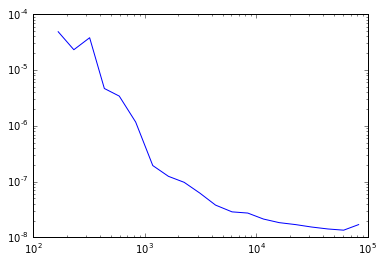

In [4]:
plt.loglog(ciber_ell,ciber_delta**2/ciber_ell**2)

In [5]:
matplotlib.rcParams.update({'font.size': 18})
plt.rc('font', family='Arial')
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False

In [6]:
label_groups = [ \
'02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I',\
'02a57694o0298I 02a57694o0302I 02a57694o0306I 02a57694o0318I 02a57694o0322I 02a57694o0326I 02a57694o0338I 02a57694o0342I 02a57694o0346I',\
'02a57694o0301I 02a57694o0305I 02a57694o0309I 02a57694o0321I 02a57694o0325I 02a57694o0329I 02a57694o0341I 02a57694o0345I 02a57694o0349I',\
'02a57694o0300I 02a57694o0304I 02a57694o0308I 02a57694o0320I 02a57694o0324I 02a57694o0328I 02a57694o0340I 02a57694o0344I 02a57694o0348I',\
]
analysis_names = ['_'.join([l.split('o')[1] for l in label_group.split(' ')]) for label_group in label_groups]
print(analysis_names)

['0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I', '0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I', '0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I', '0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I']


In [7]:
# xcor_data_dir = '/home/abrahamn/xcor_data/'
# analysis_root = xcor_data_dir+'analysis/ATLAS_mwa57694_rereduction/'
analysis_dir = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/'
num_frames = len(analysis_names)

ir_images = [pickle.load( open( analysis_dir+a+'_6.0amin_magoffset=20_56+0_274.p', "rb" ) ) for a in analysis_names] # mask artifacts and sources

In [8]:
ir_images[0].keys()

['img_kjy_per_sr_crop',
 'lbins',
 'pspec',
 'params',
 'img_kjy_per_sr',
 'masked_img_zoom']

/home/abrahamn/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


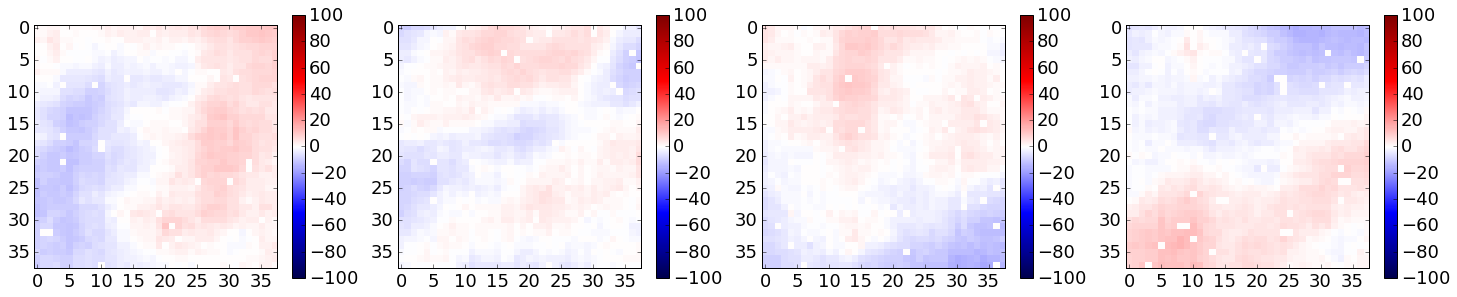

In [9]:
v1=-1.e2
v2=1.e2
cm = 'seismic'

plt.figure(figsize=(25,16))

for framei in range(num_frames):
    p = ir_images[framei]['params']
    img_crop_meansub = ir_images[framei]['img_kjy_per_sr'][p['x0']:p['x1'],p['y0']:p['y1']]
    img_crop_meansub[img_crop_meansub!=0] -= np.mean(img_crop_meansub[img_crop_meansub!=0])
    ir_images[framei]['img_kjy_per_sr_crop_meansub'] = img_crop_meansub
    
    plt.subplot(3,num_frames,framei+1)
    plt.imshow(img_crop_meansub,interpolation='nearest',cmap=cm,vmin=v1,vmax=v2)
    plt.colorbar()

In [10]:
# load MWA FHD cubes
fhdcubesroot = '/home/abrahamn/xcor_data/fhd_cubes/fhd_apb_EoR0_high_sem1_1/'

imp.reload(mwa_utils)
fhdlabel = 'Combined_obs_wedge_cut_plus_res_cut'
#fhdlabel = 'Combined_obs_golden'
#freq_averaged_cubedat0,freq_averaged_cubedat1 = mwa_utils.load_freq_averaged_odd_even_cubedat(fhdcubesroot,fhdlabel)

In [11]:
#mwa_image_full = mwa_utils.MWAImage(freq_averaged_cubedat0,freq_averaged_cubedat1, p['actual_coarse_res_amin'], int(10.*60/p['actual_coarse_res_amin']))

In [12]:
#pickle.dump(mwa_image_full,open('/home/abrahamn/xcor_data/21cmfreqavgcubes/Combined_obs_wedge_cut_plus_res_cut_6amin_10deg.p','wb'))
mwa_image_full = pickle.load(open('/home/abrahamn/xcor_data/21cmfreqavgcubes/Combined_obs_wedge_cut_plus_res_cut_6amin_10deg.p','rb'))

In [13]:
# # load and uniformly weight MWA images

# imp.reload(mwa_utils)
# mwa_images = []
# for framei in range(4):
#     p = ir_images[framei]['params']
    
#     mwa_images.append(mwa_utils.MWAImage(freq_averaged_cubedat0,freq_averaged_cubedat1, p['actual_coarse_res_amin'], ir_images[0]['img_kjy_per_sr'].shape[0],\
#                                  crop_before_uniform_weighting_params=(p['n_frame'],p['x0']+p['n_frame']/2,p['y0']+p['n_frame']/2)))

In [14]:
#pickle.dump(mwa_images,open('/home/abrahamn/xcor_data/21cmfreqavgcubes/Combined_obs_wedge_cut_plus_res_cut_4frames_6amin_10deg.p','wb'))
mwa_images = pickle.load(open('/home/abrahamn/xcor_data/21cmfreqavgcubes/Combined_obs_wedge_cut_plus_res_cut_4frames_6amin_10deg.p','rb'))

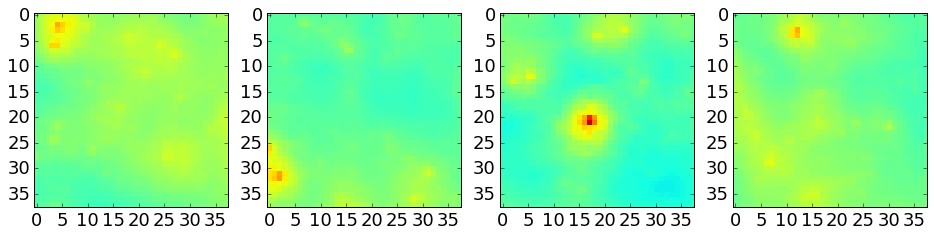

In [15]:
v1,v2 = -1.e8,1.e8
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx0,interpolation='nearest',vmin=v1,vmax=v2)

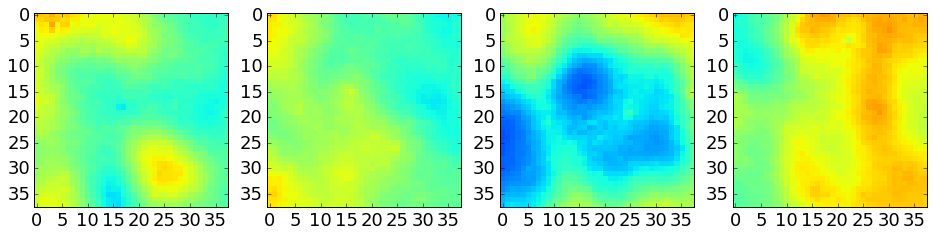

In [16]:
v1,v2 = -1.e7,1.e7
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx0-mwa_images[i].model_xx0,interpolation='nearest',vmin=v1,vmax=v2)

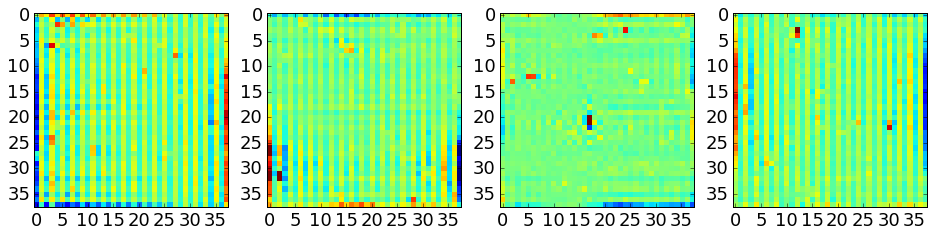

In [17]:
v1,v2 = -500,500
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx_u0,interpolation='nearest',vmin=v1,vmax=v2)

lmag.max() = 2514
lmag.max() = 2514
lmag.max() = 2514
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539
lmag.max() = 2539


(200, 2600)

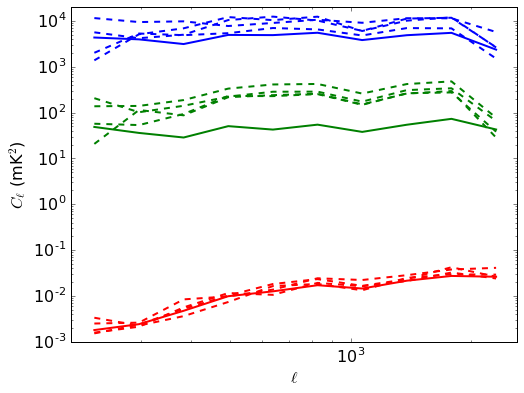

In [18]:
plt.figure(figsize=(8,6))

nbins = 10
lmin,lmax = 200,2600

use_hann = False
use_backsub=True
uselogbins=True
imp.reload(mwa_utils)
lbincenters, Cl_dirty0, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0, mwa_image_full.weights_xx0, mwa_image_full.dtheta_rad, \
                                                                   nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)
lbincenters, Cl_res0, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0 - mwa_image_full.model_xx_u0, mwa_image_full.weights_xx0,mwa_image_full.dtheta_rad, \
                                                                 nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)
lbincenters, Cl_dirty_diff, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0 - mwa_image_full.dirty_xx_u1, mwa_image_full.weights_xx0,mwa_image_full.dtheta_rad, \
                                                                       nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)

plt.loglog(lbincenters,Cl_dirty0*1.e6,'b-',linewidth=2) # the 1.e6 converts from K to mK
plt.loglog(lbincenters,Cl_res0*1.e6,'g-',linewidth=2)
plt.loglog(lbincenters,Cl_dirty_diff*1.e6,'r-',linewidth=2)

for i in range(num_frames):
    lbincenters_frame, Cl_dirty0_frame, bin_counts_frame, bin_weights_frame = mwa_utils.img2PS(mwa_images[i].dirty_xx_u0, mwa_images[i].weights_xx0, mwa_images[i].dtheta_rad,\
                                                                                               nbins,lmin,lmax,hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)
    lbincenters_frame, Cl_res0_frame, bin_counts_frame, bin_weights_frame = mwa_utils.img2PS(mwa_images[i].dirty_xx_u0 - mwa_images[i].model_xx_u0, mwa_images[i].weights_xx0,mwa_images[i].dtheta_rad,\
                                                                                             nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)
    lbincenters_frame, Cl_dirty_diff_frame, bin_counts_frame, bin_weights_frame = mwa_utils.img2PS(mwa_images[i].dirty_xx_u0 - mwa_images[i].dirty_xx_u1, mwa_images[i].weights_xx0,mwa_images[i].dtheta_rad,\
                                                                                             nbins,lmin,lmax, hann=use_hann,backsub=use_backsub,uselogbins=uselogbins)

    plt.loglog(lbincenters_frame,Cl_dirty0_frame*1.e6,'b--',linewidth=2)
    plt.loglog(lbincenters_frame,Cl_res0_frame*1.e6,'g--',linewidth=2)
    plt.loglog(lbincenters_frame,Cl_dirty_diff_frame*1.e6,'r--',linewidth=2)

matplotlib.rcParams.update({'font.size': 16})
plt.ylabel(r'$C_\ell$ (mK$^2$)')
plt.xlabel(r'$\ell$')
plt.ylim([1.e-3,2.e4])
plt.xlim([200,2600])

In [19]:
def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def calc_mwa_ir_cross_spectrum(mwa_img_u,mwa_weights_img,ir_img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,filt_small_lx_and_ly_bins=False,bin_overlap_factor=1.2):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)
    n = mwa_img_u.shape[0]
    
    lvals = np.fft.fftfreq(n)*2*pi/dtheta_rad
    dl = np.abs(lvals[1]-lvals[0])
    lx,ly = np.meshgrid(lvals,lvals)
    lmag  = np.sqrt(lx**2+ly**2)
    ft_mask = (np.abs(lx)>2*dl)&(np.abs(ly)>2*dl)
    print('\nlmax = %d'%np.max(lmag))
        
    # FFT the (MWA dirty image) and (IR image)
    ir_ft = np.fft.fft2(ir_img-ir_img.mean())
    mwa_dirty_ft = np.fft.fft2(mwa_img_u-mwa_img_u.mean())
    mwa_weights_ft = np.abs(np.fft.fft2(mwa_weights_img-mwa_weights_img.mean()))
    
    xspec_binned = np.zeros(nbins)
    mwaspec_binned = np.zeros(nbins)
    irspec_binned = np.zeros(nbins)
    
    bin_counts = np.zeros(nbins)
    bin_sum_weights = np.zeros(nbins)
    bin_sum_squared_weights = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini]/bin_overlap_factor)&(lmag<lbinedges[bini+1]*bin_overlap_factor)
        if filt_small_lx_and_ly_bins: inbin &= ft_mask
        bin_counts[bini] = np.sum(inbin)

        xspec_binned[bini] = np.sum(ir_ft[inbin]*np.conj(mwa_dirty_ft[inbin])*mwa_weights_ft[inbin])/np.sum(mwa_weights_ft[inbin])
        mwaspec_binned[bini] = np.sum(np.abs(mwa_dirty_ft[inbin])**2*mwa_weights_ft[inbin]**2)/np.sum(mwa_weights_ft[inbin]**2)
        irspec_binned[bini] = np.mean(np.abs(ir_ft[inbin])**2)
        
        bin_sum_weights[bini] = np.sum(mwa_weights_ft[inbin])
        bin_sum_squared_weights[bini] = np.sum(mwa_weights_ft[inbin]**2)
        
    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,mwaspec_binned*pspec_norm,irspec_binned*pspec_norm,xspec_binned*pspec_norm,bin_counts,bin_sum_weights,bin_sum_squared_weights

def vec2arr(v):
    return np.array(v).flatten()

def calc_mwa_ir_cross_spectrum_oqe(mwa_img_u,mwa_weights_img,ir_img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,filt_small_lx_and_ly_bins=False,verbose=False,bin_overlap_factor=1.2):
    n = ir_img.shape[0]
    norm = (dtheta_rad**2)/(n**2)*n**4
    xir = matrix(ir_img.flatten()).T
    x21 = matrix(mwa_img_u.flatten()).T
    x21weights = matrix(mwa_weights_img.flatten()).T

    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)

    lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
    dl = np.abs(lvals[1]-lvals[0])
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)

    if verbose:
        for bini in range(nbins):
            if filt_small_lx_and_ly_bins:
                ft_filt = (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])&ft_filt),lbincenters[bini]))
            else:
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])),lbincenters[bini]))
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    def gen_Ccommabini(bini,return_bin_count=False):
        inbin = (lmaggrid>lbinedges[bini]/bin_overlap_factor)*(lmaggrid<lbinedges[bini+1]*bin_overlap_factor)
        if filt_small_lx_and_ly_bins: inbin &= (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
        ivals_inbin,jvals_inbin = where(inbin)

#         lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
#         lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
#         Ccommabini_0 = matrix(exp(-1j*(lxvals*thxvals+lyvals*thyvals)))
#         Ccommabini = conj(Ccommabini_0)*Ccommabini_0.T

        thxvals,lxvals = meshgrid(thxgrid.flatten(),lxgrid[ivals_inbin,jvals_inbin]) # ell_x and theta_x
        thyvals,lyvals = meshgrid(thygrid.flatten(),lygrid[ivals_inbin,jvals_inbin]) # ell_y and theta_y
        A = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = conj(A).T*A
        
        if return_bin_count:
            return Ccommabini,A.shape[0]
        
        return Ccommabini

    print('a '),
    # generate the fourier transform matrix to transform covariances
#     lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
#     lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
#     F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2

    thxvals,lxvals = meshgrid(thxgrid.flatten(),lxgrid.flatten()) # ell_x and theta_x
    thyvals,lyvals = meshgrid(thygrid.flatten(),lygrid.flatten()) # ell_y and theta_y
    F = matrix(exp(-1j*(lxvals*thxvals+lyvals*thyvals)))/n**2

    # generate C21inv
    print('generating C21')
#     C21_ft = np.diag(np.array(1./np.abs(F*x21weights)).flatten()) # warning, this is unnormalized!!!!
    P21guess = 50.e-6
    C21_ft = matrix(np.identity(len(lmaggrid.flatten())))*P21guess/norm/n**2
    C21 = conj(F).T*C21_ft*F
    print('inverting C21')
    C21inv = inv(C21)
    
    # generate Cirinv
    print('generating Cir')
    Cirguess_ft = matrix(np.diag( 10.**np.interp(np.log10(lmaggrid.flatten()),np.log10(ciber_ell),np.log10(2*np.pi*ciber_delta**2/ciber_ell**2)/norm/n**2)) )
    #Cirsignal = F*Cirguess_ft*conj(F).T
    Cirsignal = conj(F).T*Cirguess_ft*F
    print('c '),
    Cirmask = 1.e5*np.matrix(np.diag(ir_img.flatten()==0))
    print('inverting Cir ')
    Cirinv = inv(Cirsignal + Cirmask)
    
    #return C21inv,Cirinv

    print('e '),
    # calculate q_alpha
    q21ir = np.matrix(np.zeros((nbins,1)))
    q21 = np.matrix(np.zeros((nbins,1)))
    qir = np.matrix(np.zeros((nbins,1)))
    Ccomma_times_Cirinv_mats = []
    Ccomma_times_C21inv_mats = []
    print('\nbins: '),
    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        print(bini),
        Ccommabini,bin_count = gen_Ccommabini(bini,return_bin_count=True)
        bin_counts[bini] = bin_count
        Ccomma_times_Cirinv_mats.append(Ccommabini*Cirinv)
        Ccomma_times_C21inv_mats.append(Ccommabini*C21inv)
        
        #q21ir[bini] = .5*real(x21.T*C21inv*Ccomma_times_Cirinv_mats[bini]*xir).item()
        q21ir[bini] = .5*real(xir.T*Cirinv*Ccomma_times_C21inv_mats[bini]*x21).item()
        q21[bini] = .5*real(x21.T*C21inv*Ccomma_times_C21inv_mats[bini]*x21).item()
        qir[bini] = .5*real(xir.T*Cirinv*Ccomma_times_Cirinv_mats[bini]*xir).item()

    # calculate Fisher matrix
    Fish21ir = np.matrix(np.zeros((nbins,nbins)))
    Fish21 = np.matrix(np.zeros((nbins,nbins)))
    Fishir = np.matrix(np.zeros((nbins,nbins)))
    print('\nfisher row: '),
    for i in range(nbins):
        print(i),
        for j in range(i,nbins):
            Fish21ir[i,j] = np.real(.5*trace(Ccomma_times_C21inv_mats[i]*Ccomma_times_Cirinv_mats[j]))
            Fish21ir[j,i] = Fish21ir[i,j]
            
            Fish21[i,j] = np.real(.5*trace(Ccomma_times_C21inv_mats[i]*Ccomma_times_C21inv_mats[j]))
            Fish21[j,i] = Fish21[i,j]
            
            Fishir[i,j] = np.real(.5*trace(Ccomma_times_Cirinv_mats[i]*Ccomma_times_Cirinv_mats[j]))
            Fishir[j,i] = Fishir[i,j]
    
    p021ir = vec2arr(sqrtm(inv(Fish21ir))*q21ir)*norm/vec2arr(np.max(sqrtm(Fish21ir),axis=0))
    p121ir = vec2arr(inv(Fish21ir)*q21ir*norm)
    
    p021 = vec2arr(sqrtm(inv(Fish21))*q21)*norm/vec2arr(np.max(sqrtm(Fish21),axis=0))
    p121 = vec2arr(inv(Fish21)*q21*norm)
    
    p0ir = vec2arr(sqrtm(inv(Fishir))*qir)*norm/vec2arr(np.max(sqrtm(Fishir),axis=0))
    p1ir = vec2arr(inv(Fishir)*qir*norm)

    return lbincenters,p021ir,p121ir,p021,p121,p0ir,p1ir,Fish21ir,Fish21,Fishir,bin_counts

In [20]:
lmin,lmax = 340,2600
nbins = 6

p21ir_ffts = np.zeros((num_frames,nbins))
p21_ffts = np.zeros((num_frames,nbins))
pir_ffts = np.zeros((num_frames,nbins))

p21ir_oqes0 = np.zeros((num_frames,nbins))
p21_oqes0 = np.zeros((num_frames,nbins))
pir_oqes0 = np.zeros((num_frames,nbins))

p21ir_oqes1 = np.zeros((num_frames,nbins))
p21_oqes1 = np.zeros((num_frames,nbins))
pir_oqes1 = np.zeros((num_frames,nbins))
Fish21ir_mats,Fish21_mats,Fishir_mats = [],[],[]

for framei in range(num_frames):
    lbins,p21_fft,pir_fft,p21ir_fft,bin_counts,bin_sum_weights,bin_sum_sq_weights = calc_mwa_ir_cross_spectrum(mwa_images[framei].dirty_xx_u0 - mwa_images[framei].model_xx_u0,\
                                                                                                          mwa_images[framei].weights_xx0,\
                                                                                                          ir_images[framei]['img_kjy_per_sr_crop_meansub'],\
                                                                                                          dtheta_rad=ir_images[0]['params']['actual_coarse_res_amin']/60*np.pi/180.,\
                                                                                                          nbins=nbins,lmin=lmin,lmax=lmax,\
                                                                                                         filt_small_lx_and_ly_bins=True,\
                                                                                                              bin_overlap_factor=1.1)
    p21ir_ffts[framei,:] = p21ir_fft
    p21_ffts[framei,:] = p21_fft
    pir_ffts[framei,:] = pir_fft
    
    
    lbins,p021ir,p121ir,p021,p121,p0ir,p1ir,Fish21ir,Fish21,Fishir,bin_counts = calc_mwa_ir_cross_spectrum_oqe(mwa_images[framei].dirty_xx_u0 - mwa_images[framei].model_xx_u0,\
                                                                          mwa_images[framei].weights_xx0,\
                                                                          ir_images[framei]['img_kjy_per_sr_crop_meansub'],\
                                                                          dtheta_rad=ir_images[0]['params']['actual_coarse_res_amin']/60*np.pi/180.,\
                                                                          nbins=nbins,lmin=lmin,lmax=lmax,\
                                                                          filt_small_lx_and_ly_bins=True,verbose=(framei==0),\
                                                                                                   bin_overlap_factor=1.1)
                                                                                                 
    p21ir_oqes0[framei,:] = p021ir
    p21_oqes0[framei,:] = p021
    pir_oqes0[framei,:] = p0ir
    
    p21ir_oqes1[framei,:] = p121ir
    p21_oqes1[framei,:] = p121
    pir_oqes1[framei,:] = p1ir
    
    Fish21ir_mats.append(Fish21ir)
    Fish21_mats.append(Fish21)
    Fishir_mats.append(Fishir)

# irspecs,mwaspecs,xspecs = np.array(irspecs),np.array(mwaspecs),np.array(xspecs)
# irspecs_mean = np.mean(irspecs,axis=0)
# mwaspecs_mean = np.mean(mwaspecs,axis=0)
# xspecs_mean = np.mean(xspecs,axis=0)


lmax = 2539

dl = 94
12 cells in \ell=408.6 bin
32 cells in \ell=573.5 bin
96 cells in \ell=805.0 bin
224 cells in \ell=1130.0 bin
464 cells in \ell=1586.0 bin
261 cells in \ell=2226.2 bin
a 

/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


 generating C21
inverting C21
generating Cir


/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:117: RuntimeWarning: divide by zero encountered in log10


c  inverting Cir 
e  
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5 
lmax = 2539

dl = 94
a  generating C21
inverting C21
generating Cir
c  inverting Cir 
e  
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5 
lmax = 2539

dl = 94
a  generating C21
inverting C21
generating Cir
c  inverting Cir 
e  
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5 
lmax = 2539

dl = 94
a  generating C21
inverting C21
generating Cir
c  inverting Cir 
e  
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5


In [21]:
bin_counts

array([  12.,   56.,  156.,  360.,  684.,  417.])

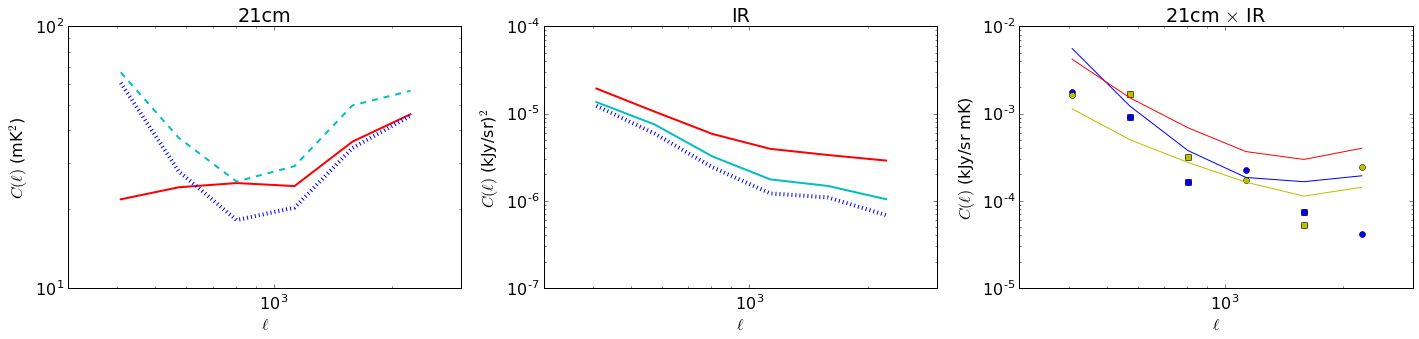

In [22]:
# DEBUGGING PLOT

plt.figure(figsize=(20,5))
matplotlib.rcParams.update({'font.size': 16})

x1,x2 = 300,3000

plt.subplot(131)
# for i in range(num_frames):
#     plt.loglog(lbins,p21_ffts[i,:]*1.e6,'r.-')
#     plt.loglog(lbins,p21_oqes0[i]*1.e6,'c--')
#     plt.loglog(lbins,p21_oqes1[i]*1.e6,'bo')
    
plt.loglog(lbins,np.mean(p21_ffts,axis=0)*1.e6,'r-',linewidth=2)
plt.loglog(lbins,np.mean(p21_oqes0,axis=0)*1.e6,'c--',linewidth=2)
plt.loglog(lbins,np.mean(p21_oqes1,axis=0)*1.e6,'b:',linewidth=4)
plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (mK$^2$)')
plt.title('21cm')
plt.xlim([x1,x2])
#plt.ylim([1.e-3,1.e4])

plt.subplot(132)
# for i in range(num_frames):
#     plt.loglog(lbins,pir_ffts[i,:],'r.-')
#     plt.loglog(lbins,pir_oqes0[i],'c-')
#     plt.loglog(lbins,pir_oqes1[i],'bo')
    
plt.loglog(lbins,np.mean(pir_ffts,axis=0),'r-',linewidth=2)
plt.loglog(lbins,np.mean(pir_oqes0,axis=0),'c-',linewidth=2)
plt.loglog(lbins,np.mean(pir_oqes1,axis=0),'b:',linewidth=4)
plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (kJy/sr)$^2$')
plt.title('IR')
plt.xlim([x1,x2])
#plt.ylim([.01,200])
#plt.ylim([1.e-6,1.e-2])

def plot_curve_with_neg_and_pos_vals(xvals,yvals,col,sty='-'):
    isneg = yvals<0
    plt.loglog(xvals,np.abs(yvals[:])*1.e3,col+'o'+sty)
    plt.loglog(xvals[isneg],-yvals[isneg]*1.e3,col+'s')
    
plt.subplot(133)
# for i in range(num_frames):
#     plot_curve_with_neg_and_pos_vals(lbins,p21ir_ffts[i,:],'r')
#     plot_curve_with_neg_and_pos_vals(lbins,p21ir_oqes0[i,:],'c')
#     plot_curve_with_neg_and_pos_vals(lbins,p21ir_oqes1[i,:],'b')
    
plot_curve_with_neg_and_pos_vals(lbins,np.mean(p21ir_ffts,axis=0),'b',sty='')
# plot_curve_with_neg_and_pos_vals(lbins,np.mean(p21ir_oqes0,axis=0),'c')
plot_curve_with_neg_and_pos_vals(lbins,np.mean(p21ir_oqes1,axis=0),'y',sty='')

n = mwa_images[framei].dirty_xx_u0.shape[0]
dtheta_rad = 6./60*np.pi/180.
norm = (dtheta_rad**2)/(n**2)*n**4*n**4
plt.loglog(lbins,1.e3*norm/np.sqrt(np.diag(4*Fish21ir_mats[0])),'y-')

plt.loglog(lbins,np.sqrt(2*np.mean(p21_oqes1,axis=0)*1.e6*np.mean(pir_oqes1,axis=0)/(4*bin_counts)),'b-')
plt.loglog(lbins,np.sqrt(2*np.mean(p21_ffts,axis=0)*1.e6*np.mean(pir_ffts,axis=0)/(4*bin_counts)),'r-')
    
plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (kJy/sr mK)')
plt.title(r'21cm $\times$ IR')
plt.xlim([x1,x2])

plt.tight_layout()

#plt.savefig('radio_and_ir_xspec_allhann.pdf',bbox_inches='tight')

In [23]:
# # DEBUGGING PLOT

# plt.figure(figsize=(8,6))
# plt.loglog(lbins,np.sqrt(lbins**2/6.28*1.e3*norm/np.diag(sqrtm(4*Fish21ir_mats[0]))),'y-')
# plt.loglog(lbins,np.sqrt(lbins**2/6.28*np.sqrt(np.mean(p21_ffts,axis=0)*1.e6*np.mean(pir_ffts,axis=0)/(4*bin_counts))),'b-')
    
# plt.xlabel('$\ell$')
# plt.ylabel('$\Delta(\ell)$ (kJy/sr mK)$^{1/2}$')
# plt.title(r'21cm $\times$ IR')
# plt.xlim([x1,x2])

# plt.tight_layout()
# plt.xlim([300,3.e4])
# plt.ylim([5.e-3,200])


# #plt.savefig('radio_and_ir_xspec_allhann.pdf',bbox_inches='tight')

In [24]:
bin_counts

array([  12.,   56.,  156.,  360.,  684.,  417.])

In [25]:
lbins_2Dsim_opt,pspec_ly_2Dsim_opt,pspec_21_2Dsim_opt,xspec_2Dsim_opt,units_opt = pickle.load(open('end_to_end_sim/2D_21cm_and_IR_spectra_from_3D_sims_opt.p','rb'))
lbins_2Dsim_pess,pspec_ly_2Dsim_pess,pspec_21_2Dsim_pess,xspec_2Dsim_pess,units_pess = pickle.load(open('end_to_end_sim/2D_21cm_and_IR_spectra_from_3D_sims_pess.p','rb'))

print(units_opt)

mK^2, (kJy/sr)^2, (mK kJy)


In [26]:
lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=True)
lbinwidths = lbinedges[1:]-lbinedges[:-1]
def plot_sensitivity_with_bin_steps(v,sty,label,col='b',lw=1):
    for i in range(len(v)-1):
        plt.plot([lbinedges[i],lbinedges[i+1],lbinedges[i+1]] ,[v[i],v[i],v[i+1]],col+sty,linewidth=lw)
    plt.plot([lbinedges[-2],lbinedges[-1]],[v[-1],v[-1]],col+sty,linewidth=lw,label=label)

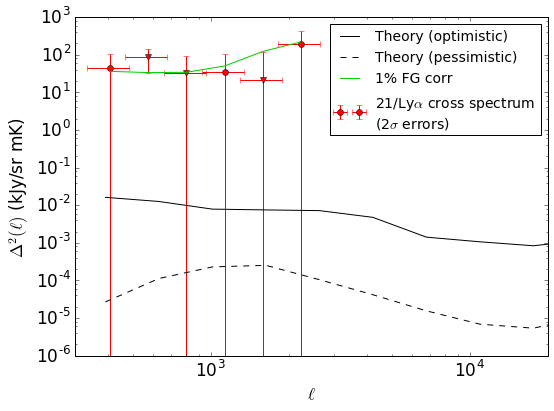

In [36]:
# PUBLICATION PLOT

plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 17})

x1,x2 = 300,3000

n = mwa_images[framei].dirty_xx_u0.shape[0]
dtheta_rad = 6./60*np.pi/180.
norm = (dtheta_rad**2)/(n**2)*n**4*n**4

# cross spectra and errors
dp = 1.e3*norm/np.diag(sqrtm(4*Fish21ir_mats[0]))
p = 1.e3*np.mean(p21ir_oqes1,axis=0)
DeltaSq = lbins**2*np.abs(p)/(2*np.pi)
dDeltaSq = lbins**2*dp/(2*np.pi)

# dDelta2 = np.sqrt(lbins**2/6.28*1.e3*norm/np.diag(sqrtm(4*Fish21ir_mats[0])))

# auto spectra
p21 = 1.e6*np.mean(p21_oqes1,axis=0) # mK^2
Delta21Sq = lbins**2*p21/(2*np.pi)
pir = np.mean(pir_oqes1,axis=0) # (kJy/sr)^2
DeltairSq = lbins**2*pir/(2*np.pi)

ispos = p>0
isneg = p<0
bin_overlap_factor=1.1 # this screws up the agreement between the FFT and OQE methods if I set it something other than 1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
plt.errorbar(lbins[ispos],DeltaSq[ispos],yerr=2*dDeltaSq[ispos],xerr=.5*lbinwidths[ispos]*bin_overlap_factor,color='r',fmt='o',label='21/Ly$\\alpha$ cross spectrum\n(2$\sigma$ errors)')
plt.errorbar(lbins[isneg],DeltaSq[isneg],yerr=2*dDeltaSq[isneg],xerr=.5*lbinwidths[isneg]*bin_overlap_factor,color='r',fmt='v')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

# plt.errorbar(lbins,Delta,uplims=True)
 
plt.xlabel('$\ell$')
plt.ylabel('$\Delta^2(\ell)$ (kJy/sr mK)')
plt.xlim([300,2.e4])
#plt.ylim([1.e-3,100])

plt.plot(lbins_2Dsim_opt,lbins_2Dsim_opt**2/(2*np.pi)*np.abs(xspec_2Dsim_opt)*1.e3,'k',label='Theory (optimistic)')
plt.plot(lbins_2Dsim_pess,lbins_2Dsim_pess**2/(2*np.pi)*np.abs(xspec_2Dsim_pess)*1.e3,'k--',label='Theory (pessimistic)')

cfg = .01
plt.plot(lbins,cfg*np.sqrt(Delta21Sq*DeltairSq),'-',label='1% FG corr',color='#00cc00')

plt.legend(fontsize=14,loc=1)
plt.tight_layout()

plt.savefig('mwa_atlas_xspec_with_2Dsimtheory_and_2sigma_errors_6bins.pdf',bbox_inches='tight')

In [ ]:
1

In [28]:
lbins

array([  408.61513849,   573.5397521 ,   805.03098456,  1129.95635215,
        1586.02759677,  2226.17761556])

In [29]:
Delta+2*dDelta

NameError: name 'Delta' is not defined

In [ ]:
Delta[ispos]+2*dDelta[ispos],Delta[ispos]-2*dDelta[ispos]

In [ ]:
-Delta[isneg]+2*dDelta[isneg],-Delta[isneg]-2*dDelta[isneg]

In [ ]:
bin_counts

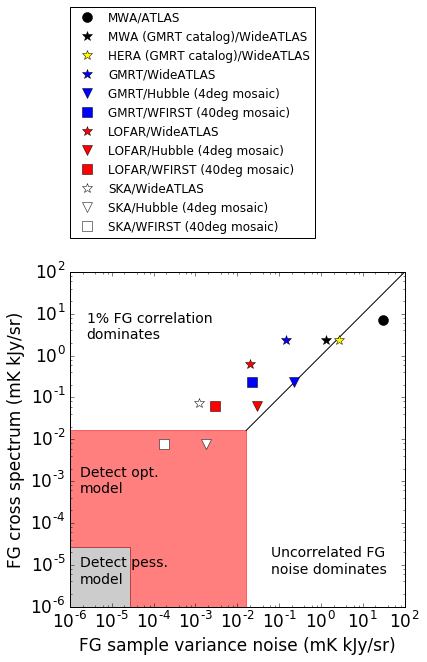

In [34]:
fov_deg_curr = 8.
dtheta_amin_curr = 6.

plt.figure(figsize=(6,6))

# radio, expt name, dtheta (amin), flux limit in mJy, radio FG residual power relative to MWA
mwa = ['MWA',dtheta_amin_curr,150.,1.,'k']
hera_gmrtcat = ['HERA (GMRT catalog)',12.,25.,(25./150)**1.25,'#ffff00']
mwa_gmrtcat = ['MWA (GMRT catalog)',dtheta_amin_curr,25.,(25./150)**1.25,'k']
gmrt = ['GMRT',40./60,25.,(25./150)**1.25,'b'] # http://www.aoc.nrao.edu/~sbhatnag/Thesis/HTLATEX/SanB/thesisch5.html shows that uv coverage is reasonably complete out to ~10km
lofar = ['LOFAR',20./60,3,(3./150)**1.25,'r'] # fig 4 in https://arxiv.org/pdf/1301.1630.pdf shows the uv coverage is reasonably complete out to 20km
ska = ['SKA',10./60,.1,(.1/150)**1.25,'w']

# IR, expt name, fov (deg), fov (deg), IR FG residual power relative to ATLAS
atlas = ['ATLAS',fov_deg_curr,1.,'o']
wideatlas = ['WideATLAS',60.,1.,'*']
hubble = ['Hubble (4deg mosaic)',4.,.01,'v']
wfirst = ['WFIRST (40deg mosaic)',40.,.01,'s']


poptmean = lbins_2Dsim_opt[0]**2/(2*np.pi)*np.abs(xspec_2Dsim_opt[0])*1.e3
ppessmean = lbins_2Dsim_pess[0]**2/(2*np.pi)*np.abs(xspec_2Dsim_pess[0])*1.e3
v = 10.**np.linspace(np.log10(poptmean),2)
plt.loglog(v,v,'k-')

cfg = .01
expt_pairs = [[mwa,atlas],
              [mwa_gmrtcat,wideatlas],
              [hera_gmrtcat,wideatlas],
              [gmrt,wideatlas],
              [gmrt,hubble],
              [gmrt,wfirst],
              [lofar,wideatlas],
              [lofar,hubble],
              [lofar,wfirst],
              [ska,wideatlas],
              [ska,hubble],
              [ska,wfirst]]
for i in range(len(expt_pairs)):
    expt_pair = expt_pairs[i]
    
    rad_expt, ir_expt = expt_pair
    rad_expt_name, dtheta_amin, flux_limit_mJy, radio_fg_res_power_rel_mwa,col = rad_expt
    ir_expt_name, fov_deg, ir_fg_res_power_rel_atlas,mark  = ir_expt
    sty = mark
    
    plt.loglog((dDeltaSq[0])*(fov_deg_curr/fov_deg)*(dtheta_amin/dtheta_amin_curr)*sqrt(ir_fg_res_power_rel_atlas*radio_fg_res_power_rel_mwa),\
           cfg*(np.sqrt(Delta21Sq[0]*DeltairSq[0]))*sqrt(ir_fg_res_power_rel_atlas*radio_fg_res_power_rel_mwa),sty,label=rad_expt_name+'/'+ir_expt_name,markersize=10,color=col)
    

plt.fill_between([1.e-8,ppessmean,ppessmean,poptmean], [ppessmean,ppessmean,1.e-8,1.e-8], [poptmean,poptmean,poptmean,poptmean],alpha=.5,color='red')
plt.fill_between([1.e-8,ppessmean], [1.e-8,1.e-8], [ppessmean,ppessmean],alpha=.2,color='black')

plt.legend(fontsize=12,loc=(0,1.1),numpoints=1)

ax = plt.gca()
plt.text(.05,.8,'1% FG correlation\ndominates',fontsize=14,transform=ax.transAxes)
plt.text(.6,.1,'Uncorrelated FG\nnoise dominates',fontsize=14,transform=ax.transAxes)

plt.text(.03,.34,'Detect opt.\nmodel',fontsize=14,transform=ax.transAxes)
plt.text(.03,.07,'Detect pess.\nmodel',fontsize=14,transform=ax.transAxes)

plt.xlabel('FG sample variance noise (mK kJy/sr)')
plt.ylabel('FG cross spectrum (mK kJy/sr)')

plt.ylim([1.e-6,1.e2])
plt.xlim([1.e-6,1.e2])
plt.axes().set_aspect('equal')

plt.savefig('noise_vs_corr_expt_study.pdf',bbox_inches='tight')

In [33]:
poptmean

array([  1.62081143e-02,   4.19876772e-02,   1.08770521e-01,
         2.81773772e-01,   7.29944639e-01,   1.89094667e+00,
         4.89856234e+00,   1.26898941e+01,   3.28736067e+01,
         8.51602079e+01])

In [ ]:
rad_expts = [mwa,mwa_gmrtcat,hera_gmrtcat,gmrt,lofar,ska]
ir_expts = [atlas,wideatlas,hubble,wfirst]

In [ ]:
print('\\begin{center}')
print('\\begin{tabular}{|l | l | l|}')
print('\hline')

print('\\textbf{Radio Survey} & \\textbf{Resolution} & \\textbf{Flux Limit} \\\\')
print('\hline')
for rad_expt in rad_expts:
    rad_expt_name, dtheta_amin, flux_limit_mJy, radio_fg_res_power_rel_mwa,col = rad_expt
    dtheta_str = str(int(dtheta_amin))+'\'' if dtheta_amin>1 else str(int(dtheta_amin*60))+'\'\''
    
    flux_limit_mJy_str = str(int(flux_limit_mJy)) if flux_limit_mJy>1 else '%.1f'%(flux_limit_mJy)
    
#     if '*' in rad_expt_name:
#         rad_expt_name = rad_expt_name[:-1]+' (GMRT catalog)'
    
    print('%s & $%s$ & %s mJy \\\\'%(rad_expt_name,dtheta_str,flux_limit_mJy_str))
    
print('\hline\hline')
print('\\textbf{IR Survey} & \\textbf{Field of View} & \\textbf{FG power} \\\\')
print('& & \\textbf{wrt ATLAS}\\\\')
print('\hline')
for ir_expt in ir_expts:
    ir_expt_name, fov_deg, ir_fg_res_power_rel_atlas,mark  = ir_expt
    fov_deg_str = str(int(fov_deg))+'^\circ' if fov_deg>1 else str(int(fov_deg*60))+'\''
    
    print('%s & $%s$ & %s \\\\'%(ir_expt_name,fov_deg_str,ir_fg_res_power_rel_atlas))

print('\hline')
print('\end{tabular}')
print('\end{center}')

In [ ]:
what is the GMRT confusion limit compared to the MWA confusion limit?

In [ ]:
what is the GMRT confusion limit compared to the MWA confusion limit

In [ ]:
Delta+2*dDelta # 6bins

In [ ]:
Delta+2*dDelta # 4bins

In [ ]:
cols = ['r','g','b','k','c','y']
wmaxs = np.zeros(nbins)
for i in range(nbins):
    w = np.abs(vec2arr(sqrtm(Fish21ir_mats[0])[:,i]))
    print(w)
    wmaxs[i] = np.max(w)
    plt.loglog(lbins,w/np.max(w)+1.e-16,cols[i])
plt.xlim([x1,x2])